setup

In [339]:
import copy
import time
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np
import pdb

In [340]:
import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable

In [341]:
matplotlib.rcParams['figure.figsize'] = 12,8

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DQN

In [169]:
torch.cuda.is_available()

True

In [170]:
dtype = torch.cuda.FloatTensor

In [178]:
class dqn(nn.Module):
    
    def __init__(self):
        super(dqn, self).__init__()
        
        self.net = nn.Sequential(
                                nn.Linear(1, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 2)
                                )
        
    def forward(self, distance):
        return self.net(distance)

test network with random data

In [258]:
tic = time.clock()
N = 1

model = dqn().type(dtype)
distance = Variable(torch.randn(N,1)).type(dtype)
Q = model(distance)
toc = time.clock()

print(Q)
print(Q.size())
print('%0.2fs = %0.2fm elapsed for this test' %(toc-tic,(toc-tic)/60))

tensor([[0.1444, 0.3187]], device='cuda:0', grad_fn=<ThAddmmBackward>)
torch.Size([1, 2])
0.00s = 0.00m elapsed for this test


grid world functions

In [89]:
class grid_agent(object):
    
    def __init__(self, x_max, y_max):
        self.position = (np.random.randint(1,x_max+1), 
                        np.random.randint(1,y_max+1))
        self.x_max = x_max
        self.y_max = y_max
        
    def move(self, delta):
        """
        move - 1 2 3
               4 0 5
               6 7 8
        """
        self.position = (self.position[0]+delta[0],
                         self.position[1]+delta[1])
#         if action == 0:
#             pass
#         elif action == 1:
#             self.position = (self.position[0]-1,self.position[1]+1)
#         elif action == 2:
#             self.position = (self.position[0]  ,self.position[1]+1)
#         elif action == 3:
#             self.position = (self.position[0]+1,self.position[1]+1)
#         elif action == 4:
#             self.position = (self.position[0]-1,self.position[1])
#         elif action == 5:
#             self.position = (self.position[0]+1,self.position[1])
#         elif action == 6:
#             self.position = (self.position[0]-1,self.position[1]-1)
#         elif action == 7:
#             self.position = (self.position[0]  ,self.position[1]-1)
#         elif action == 8:
#             self.position = (self.position[0]+1,self.position[1]-1)
            
        if self.position[0] < 1:
            self.position[0] = 1
        elif self.position[0] > x_max:
            self.position[0] = x_max
            
        if self.position[1] < 1:
            self.position[1] = 1
        elif self.position[1] > y_max:
            self.position[1] = y_max

        return
        

In [318]:
def observation(goal, eps):
    if eps >= 0 and eps < 0.2:
        return (goal[0]-1,goal[1])
    elif eps >= 0.2 and eps < 0.4:
        return (goal[0],goal[1]+1)
    elif eps >= 0.4 and eps < 0.6:
        return (goal[0]+1,goal[1])
    elif eps >= 0.6 and eps < 0.8:
        return (goal[0],goal[1]-1)
    else:
        return goal

train the network

In [319]:
# replay setup
memory_size = 1000000
min_exp_size = 500
sarst = None

# network instance
model = dqn().type(dtype)
target = dqn().type(dtype)
update_max = 250
update_ctr = 1

# optimizer
gamma = 0.99
batch_size = 32
optimizer = opt.Adam(model.parameters(), lr=1e-4)

# exploration
eps_init = 1
eps_finl = 0.15
anneal_range = 1000
eps = eps_init

# loss function
loss_fn = nn.MSELoss(reduction='elementwise_mean')
rew_hist = []
loss_hist = []

# flags
pf1 = False
pf2 = False

training loop

In [320]:
num_episodes = 2000

In [321]:
x_max = 10
y_max = 10

goal = (x_max-1,y_max-1)
movements = [(-1,-1),(-1,0),(-1,1),
             (0,-1),(0,0),(0,1),
             (1,-1),(1,0),(1,1)]

for episode in range(num_episodes):
    agent = grid_agent(x_max, y_max)
    done = False
    r = 0
    
    if sarst is None:
        sarst = np.zeros((1,5))
    else:
        sarst = np.vstack((sarst,np.zeros((1,5))))
        
    noisy_goal = observation(goal, np.random.rand())
    current_distance = np.abs(agent.position[0]-noisy_goal[0]) + np.abs(agent.position[1]-noisy_goal[1])
    sarst[-1,0] = current_distance
    
    t = 1
    while not done:
        
        if np.random.rand() <= eps:
            action = np.random.randint(0,2)
        else:
            state = Variable(torch.from_numpy(np.array(sarst[-1,0]))).type(dtype)
            Q = model(state.unsqueeze(0)).data.cpu().numpy()
            action = np.argmax(Q)
            
        delta = None
        values = []
        if action == 0:
            for idx,(dx,dy) in enumerate(movements):
                distance = np.abs(agent.position[0]+dx-noisy_goal[0]) + \
                           np.abs(agent.position[1]+dy-noisy_goal[1])
                values.append((distance,idx))

            _, choice = min(values)
            delta = movements[choice]

        elif action == 1:
            for idx,(dx,dy) in enumerate(movements):
                distance = np.abs(agent.position[0]+dx-goal[0]) + \
                           np.abs(agent.position[1]+dy-goal[1])
                values.append((distance,idx))

            _, choice = min(values)
            delta = movements[choice]
            
            r += -1
        
        r += -1
        agent.move(delta)
        
        if agent.position[0] == goal[0] and agent.position[1] == goal[1]:
            r += min([x_max, y_max])
            done = True
        if t >= min([x_max, y_max]):
            done = True
        
        noisy_goal = observation(goal, np.random.rand())
        next_distance = np.abs(agent.position[0]-noisy_goal[0]) + np.abs(agent.position[1]-noisy_goal[1])
        sarst[-1,1] = action
        sarst[-1,2] = r
        sarst[-1,3] = next_distance
        sarst[-1,4] = done
        
        if not done:
            sarst = np.vstack((sarst, np.zeros((1,5))))
            sarst[-1,0] = next_distance
            t += 1
            
        if sarst.shape[0] < min_exp_size or sarst.shape[0] < batch_size:
            continue
        elif not pf1:
            pf1 = True
            # print('---DEBUG: generated enough experiences')
            
        loss = 0
        batch = sarst[np.random.choice(sarst.shape[0], batch_size, replace=False), :]
        batch_states = Variable(torch.from_numpy(batch[:,0])).type(dtype).unsqueeze(1)
        batch_actions = Variable(torch.from_numpy(batch[:,1])).type(torch.cuda.LongTensor)
        x = model(batch_states).gather(1, batch_actions.view(-1, 1)).squeeze()
        
        batch_next_states = Variable(torch.from_numpy(batch[:,3])).type(dtype).unsqueeze(1)
        tt = target(batch_next_states).data.cpu().numpy()
        tt = batch[:,2] + gamma*(1-batch[:,4])*np.amax(tt, axis=1)
        tt = Variable(torch.from_numpy(tt), requires_grad=False).type(dtype)
        loss += loss_fn(x, tt)
        
        loss_hist.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # anneal exploration rate
        if eps > eps_finl:
            eps += -(eps_init - eps_finl)/anneal_range
        elif not pf2:
            pf2 = True
            # print('---DEBUG: finished annealing the exploration rate')
        
        # update target network periodically
        if update_ctr % update_max == 0:
            target = copy.deepcopy(model)
            # print('---DEBUG: updated target network (%d)' %(update_ctr / update_max))
        update_ctr += 1
        
        # drop from memory if too many elements
        if sarst.shape[0] > memory_size:
            sarst = sarst[sarst.shape[0]-memory_size:,:]
        
    # print('episode %d: %d steps, %d reward' %(episode, t, r))
    
    if (episode+1)%100 == 0:
        print('finished %d episodes' %(episode+1))
    
    rew_hist.append(r)


finished 100 episodes
finished 200 episodes
finished 300 episodes
finished 400 episodes
finished 500 episodes
finished 600 episodes
finished 700 episodes
finished 800 episodes
finished 900 episodes
finished 1000 episodes
finished 1100 episodes
finished 1200 episodes
finished 1300 episodes
finished 1400 episodes
finished 1500 episodes
finished 1600 episodes
finished 1700 episodes
finished 1800 episodes
finished 1900 episodes
finished 2000 episodes


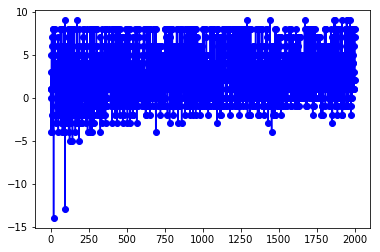

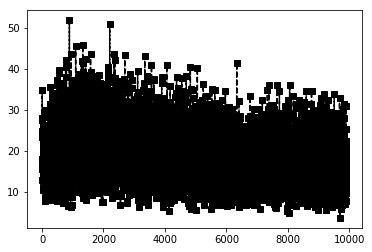

In [322]:
fig = pyplot.figure()
pyplot.plot(range(len(rew_hist)), rew_hist, 'b-o')

fig = pyplot.figure()
pyplot.plot(range(len(loss_hist)), loss_hist, 'k--s')

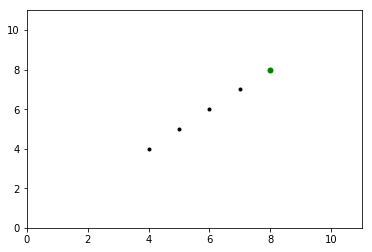

In [348]:
x_max = 10
y_max = 10

goal = (x_max-1,y_max-1)
movements = [(-1,-1),(-1,0),(-1,1),
             (0,-1),(0,0),(0,1),
             (1,-1),(1,0),(1,1)]

agent = grid_agent(x_max, y_max)

pyplot.figure()
pyplot.xlim([0,x_max+1])
pyplot.ylim([0,y_max+1])

for t in range(min([x_max, y_max])):
    
    if agent.position[0] == goal[0] and agent.position[1] == goal[1]:
        break
    
    noisy_goal = observation(goal, np.random.rand())
    current_distance = np.abs(agent.position[0]-noisy_goal[0]) + np.abs(agent.position[1]-noisy_goal[1])
    
    state = Variable(torch.from_numpy(np.array(current_distance))).type(dtype)
    Q = model(state.unsqueeze(0)).data.cpu().numpy()
    action = np.argmax(Q)
    
    delta = None
    values = []
    if action == 0:
        for idx,(dx,dy) in enumerate(movements):
            distance = np.abs(agent.position[0]+dx-noisy_goal[0]) + \
                       np.abs(agent.position[1]+dy-noisy_goal[1])
            values.append((distance,idx))

        _, choice = min(values)
        delta = movements[choice]

    elif action == 1:
        for idx,(dx,dy) in enumerate(movements):
            distance = np.abs(agent.position[0]+dx-goal[0]) + \
                       np.abs(agent.position[1]+dy-goal[1])
            values.append((distance,idx))

        _, choice = min(values)
        delta = movements[choice]
    
    if action == 0:
        pyplot.plot(agent.position[0], agent.position[1], 'k.')
    elif action == 1:
        pyplot.plot(agent.position[0], agent.position[1], 'g.', MarkerSize=10)
    
    agent.move(delta)
    
pyplot.show()

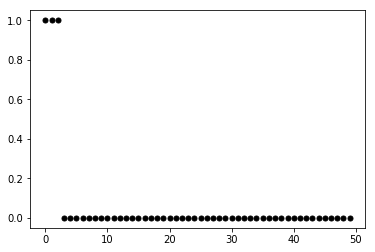

In [351]:
pyplot.figure()
for distance in range(50):
    state = Variable(torch.from_numpy(np.array(distance))).type(dtype)
    Q = model(state.unsqueeze(0)).data.cpu().numpy()
    action = np.argmax(Q)
    
    pyplot.plot(distance, action, 'k.', Markersize=10)